<a href="https://colab.research.google.com/github/soutrik71/School_of_AI_ERA/blob/main/Soutrik_ERA_Session_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CODE BLOCK: 1

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary

CODE BLOCK: 2

In [2]:
# CUDA?
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device Available?", device)

device Available? cuda


CODE BLOCK: 3

In [3]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),  # Apply randomly a list of transformations with a given probability
    transforms.Resize((28, 28)),  # Resize the image to the given size
    transforms.RandomRotation((-15., 15.), fill=0),  # Rotate the image by an angle
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize((0.1307,), (0.3081,)), # Normalize a tensor image with mean and standard deviation.
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(), # PIL to tensor
    transforms.Normalize((0.1307,), (0.3081,)) # Normalize a tensor image with mean and standard deviation.
    ])

CODE BLOCK: 4

In [4]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 292111961.42it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 44732530.95it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 192503796.60it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 22518355.52it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



CODE BLOCK: 5

In [5]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(train_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 6

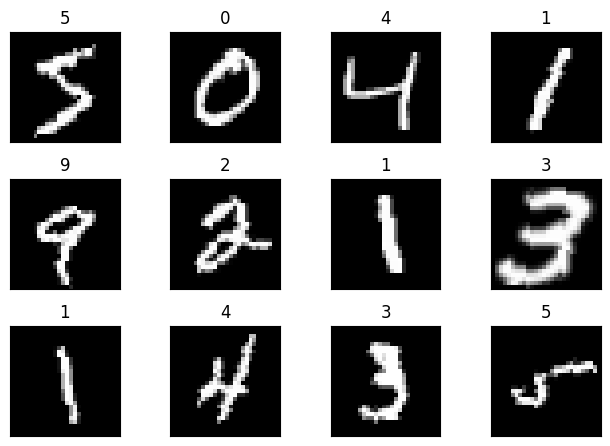

In [6]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [8]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        self.fc1 = nn.Linear(4096, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x), 2)  # ip: -1,1,28,28  op: -1,32,26,26
        x = F.relu(F.max_pool2d(self.conv2(x), 2))  # ip: -1,32,26,26  op1: -1,64,24,24 op2: -1,64,12,12
        x = F.relu(self.conv3(x), 2) # ip: -1,64,12,12 op : -1,128,10,10
        x = F.relu(F.max_pool2d(self.conv4(x), 2)) # ip: -1,128,10,10  op1: -1,256,8,8  op2: -1,256,4,4
        x = x.view(-1, 4096) # ip: -1,256,4,4  op: -1, 4*4*256 ie flatten
        x = F.relu(self.fc1(x)) # ip: -1,4096  op: -1,50
        x = self.fc2(x) # ip: -1,50 op: -1,10
        return F.log_softmax(x, dim=1)

In [9]:
model = Net().to(device)
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------


CODE BLOCK: 8

In [30]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [31]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

# use this training and test method in all codes ***
def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0
  # train_acc = []
  # train_losses = []

  for batch_idx, (data, target) in enumerate(pbar):
    # print(f"train batch size:{data.shape}" )
    # print(f"train batch size:{target.shape}")
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

  return train_acc,train_losses

def test(model, device, test_loader, criterion):
    model.eval()
    pbar = tqdm(test_loader)
    test_loss = 0
    correct = 0
    # test_acc =[]
    # test_losses = []

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)
            pbar.set_description(desc= f'Test: Loss={test_loss/len(test_loader.dataset):0.4f} Accuracy={100*correct/len(test_loader.dataset):0.2f}')


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return test_acc,test_losses


CODE BLOCK: 10

In [32]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = F.nll_loss # refer:: https://stackoverflow.com/questions/65192475/pytorch-logsoftmax-vs-softmax-for-crossentropyloss
num_epochs = 5

Adjusting learning rate of group 0 to 1.0000e-02.


In [33]:
for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, train_loader, criterion)
  scheduler.step()

Epoch 1


Test: Loss=0.3968 Accuracy=87.35: 100%|██████████| 118/118 [00:19<00:00,  5.96it/s]


Test set: Average loss: 0.3968, Accuracy: 52408/60000 (87.35%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Test: Loss=0.1428 Accuracy=95.45: 100%|██████████| 118/118 [00:20<00:00,  5.75it/s]


Test set: Average loss: 0.1428, Accuracy: 57270/60000 (95.45%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Test: Loss=0.1040 Accuracy=96.78: 100%|██████████| 118/118 [00:28<00:00,  4.09it/s]


Test set: Average loss: 0.1040, Accuracy: 58068/60000 (96.78%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Test: Loss=0.0836 Accuracy=97.45: 100%|██████████| 118/118 [00:21<00:00,  5.47it/s]


Test set: Average loss: 0.0836, Accuracy: 58473/60000 (97.45%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Test: Loss=0.0752 Accuracy=97.65: 100%|██████████| 118/118 [00:27<00:00,  4.34it/s]

Test set: Average loss: 0.0752, Accuracy: 58591/60000 (97.65%)

Adjusting learning rate of group 0 to 1.0000e-02.


CODE BLOCK: 11

Text(0.5, 1.0, 'Test Accuracy')

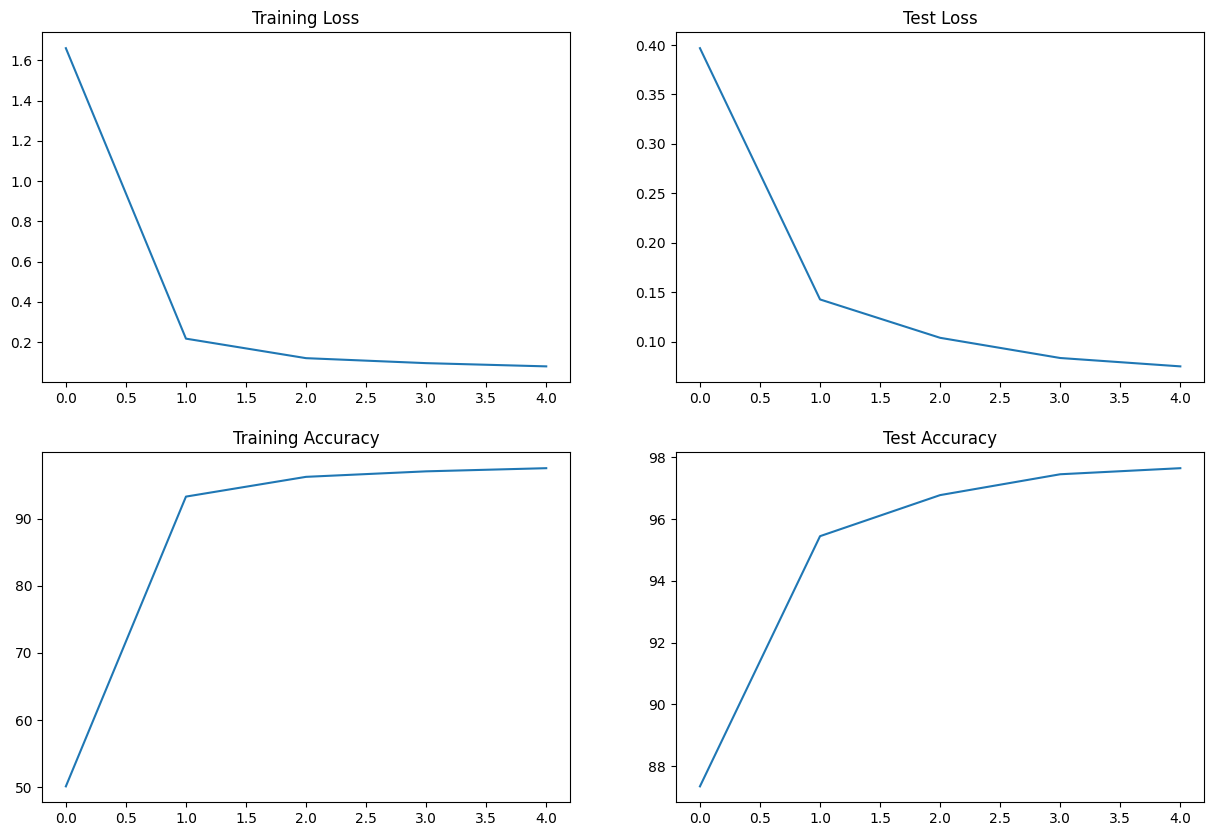

In [34]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [26]:
# !pip install torchsummary
# from torchsummary import summary
# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")
# model = Net().to(device)
# summary(model, input_size=(1, 28, 28))

#### Notes:
* Yes, NLLLoss takes log-probabilities (log(softmax(x))) as input. Why?. Because if you add a nn.LogSoftmax (or F.log_softmax) as the final layer of your model's output, you can easily get the probabilities using torch.exp(output), and in order to get cross-entropy loss, you can directly use nn.NLLLoss. Of course, log-softmax is more stable as you said.
And, there is only one log (it's in nn.LogSoftmax). There is no log in nn.NLLLoss.
nn.CrossEntropyLoss() combines nn.LogSoftmax() (that is, log(softmax(x))) and nn.NLLLoss() in one single class. Therefore, the output from the network that is passed into nn.CrossEntropyLoss needs to be the raw output of the network (called logits), not the output of the softmax function.